In [ ]:
pip install tensorflow
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2, #20% of its width to the left or right.
        height_shift_range=0.2,
        shear_range=0.2, #maximum shear intensity in radians
        zoom_range=0.2, #zoomed to a maximum of 20% larger or smaller
        horizontal_flip=True,
        fill_mode='constant', cval=125)

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

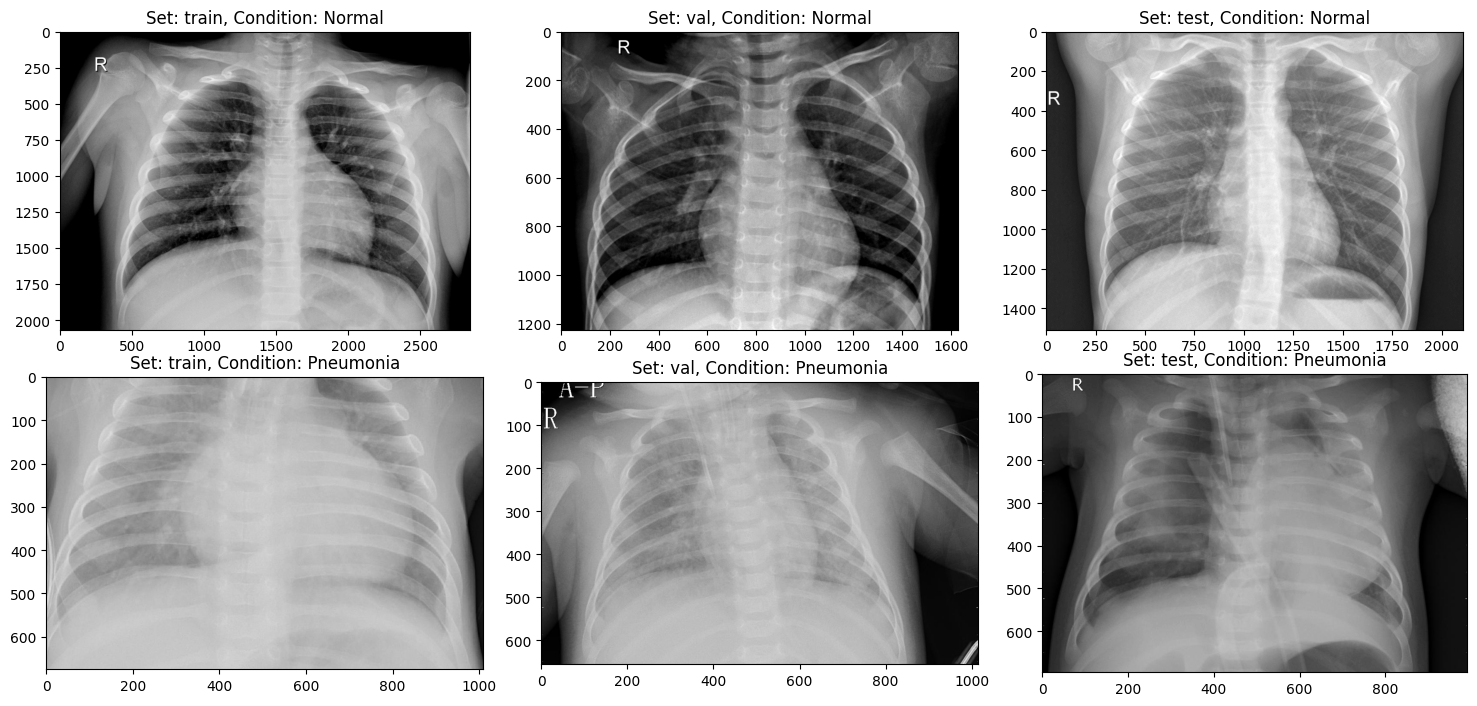

In [ ]:
# input_path = '../input/chest_xray/chest_xray/'
input_path = '/content/drive/MyDrive/Colab Notebooks/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [ ]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [ ]:
import numpy as np
from skimage import io
import os
from PIL import Image


In [ ]:
image_directory = '/content/drive/MyDrive/Colab Notebooks/chest_xray/'
SIZE = 128
dataset = []

In [ ]:
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    file_extension = image_name.split('.')[-1].lower()
    if file_extension == 'jpeg':
        image = io.imread(os.path.join(image_directory, image_name))
        image = Image.fromarray(image, 'RGB')
        image = image.resize(SIZE)
        dataset.append(np.array(image))

In [ ]:
i = 0
for batch in datagen.flow_from_directory(directory='/content/drive/MyDrive/Colab Notebooks/chest_xray/train/',
                                         batch_size=16,
                                         target_size=(256, 256),
                                         color_mode="rgb",
                                         save_prefix='aug',
                                         save_format='png'):
    i += 1
    if i > 31:
        break

Found 5216 images belonging to 2 classes.


In [ ]:
import cv2

In [ ]:
def gauss_noise(image, gauss_var=1000):
    mean = 0
    sigma = gauss_var ** 0.5
    gauss = np.random.normal(mean, sigma, image.shape)

    res = image + gauss
    noisy = np.clip(res, 0, 255).astype(np.uint8)
    return noisy


def s_and_p_noise(image, s_p_ratio=0.04):
    # this implementation is not entirely correct because it assumes that
    # only 0 OR 255 values are S&P noise.
    out = np.copy(image)

    # Salt mode
    mask = np.random.rand(image.shape[0], image.shape[1]) <= s_p_ratio / 2
    out[mask] = 255

    # Pepper mode
    mask = np.random.rand(image.shape[0], image.shape[1]) <= s_p_ratio / 2
    out[mask] = 0
    return out

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Path to the dataset
image_directory = '/content/drive/MyDrive/Colab Notebooks/chest_xray/'

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop through the train and test directories
for label in ['NORMAL', 'PNEUMONIA']:
    for dataset in ['train', 'test']:
        dir_path = os.path.join(image_directory, dataset, label)
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            image_paths.append(img_path)
            labels.append(label)

# Convert labels to binary (0: NORMAL, 1: PNEUMONIA)
label_map = {'NORMAL': 0, 'PNEUMONIA': 1}
labels = [label_map[label] for label in labels]

# Split the dataset into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels)

# Printing the number of samples in each set
print(f"Train samples: {len(train_paths)}, Test samples: {len(test_paths)}")


Train samples: 4088, Test samples: 1752


In [ ]:
import os
import cv2
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def load_images_from_directory(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Example usage
data_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train'
training_data = load_images_from_directory(data_dir)

# Print the shape of the training data
print("Training data shape:", training_data.shape)


Training data shape: (5216, 2)


<ipython-input-17-5c96125bb0ee>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
train = load_images_from_directory('/content/drive/MyDrive/Colab Notebooks/chest_xray/train')
test = load_images_from_directory('/content/drive/MyDrive/Colab Notebooks/chest_xray/test')
val = load_images_from_directory('/content/drive/MyDrive/Colab Notebooks/chest_xray/val')

<ipython-input-17-5c96125bb0ee>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


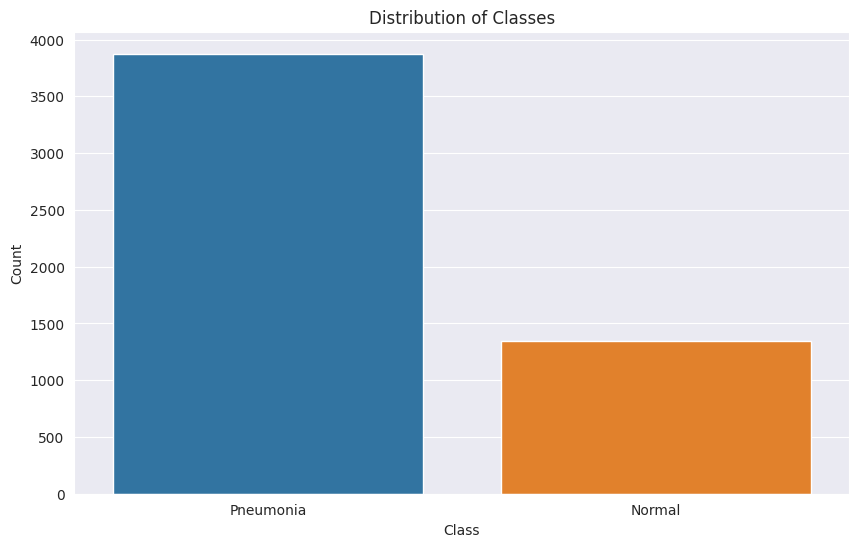

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
l = []
for i in training_data:
    if i[1] == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))

# Count the occurrences of each class label
label_counts = Counter(l)

sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

In [ ]:
x_train = [] #list to store the train data(feature)
y_train = [] #list to store the train labels

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# resize data for deep learning
# Convert data and labels to NumPy arrays
x_train = np.array(x_train).reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

#converting to numpy arrays first, then reshaping - -1: size of dimension cal based on other dimensions and num of images. 1: greyscale.

x_val = np.array(x_val).reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    featurewise_center=False, #centering the data - not.
    samplewise_center=False,
    featurewise_std_normalization=False, #divide inputs by the standard deviation of the dataset - no normalization.
    samplewise_std_normalization=False,
    zca_whitening=False, #dimension reduction technique
    rotation_range=30, #rotated by any angle between -30 and +30 degrees
    zoom_range=0.2, #20% of its original size
    width_shift_range=0.1, #shift by up to 10% of their dimensions
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape)  # Adding Gaussian noise
) # lambda func takes input x-image, random num with mean -0, SD-1, and shape x, add noise to each pixel of the image.

datagen.fit(x_train)

augmented_images_per_original = 3

augmented_x_train = []
augmented_y_train = []

for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=len(x_train), shuffle=True):
    augmented_x_train.extend(x_batch)
    augmented_y_train.extend(y_batch)

    if len(augmented_x_train) >= len(x_train) * augmented_images_per_original:
        break

# Convert lists to arrays
augmented_x_train = np.array(augmented_x_train)
augmented_y_train = np.array(augmented_y_train)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense,Dropout, BatchNormalization  # Import BatchNormalization
from keras.optimizers import Adam

model = Sequential() #build model layer-layer sequentially
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
augmented_images_per_original = 3

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),  # Training data generator
    steps_per_epoch=len(x_train) // 32,            # Number of batches per epoch
    epochs=12,                                     # Number of training epochs
    validation_data=datagen.flow(x_val, y_val),    # Validation data generator
    callbacks=[learning_rate_reduction]            # List of callbacks
)

Epoch 1/12
163/163 [==============================] - 32s 110ms/step - loss: 0.5201 - accuracy: 0.8307 - val_loss: 0.5240 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 17s 104ms/step - loss: 0.2636 - accuracy: 0.9001 - val_loss: 0.8084 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9156
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 16s 101ms/step - loss: 0.2389 - accuracy: 0.9156 - val_loss: 1.6927 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 17s 102ms/step - loss: 0.1516 - accuracy: 0.9461 - val_loss: 3.6609 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9525
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 11ms/step - loss: 0.2380 - accuracy: 0.9231
Loss of the model is -  0.23798061907291412
20/20 [==============================] - 0s 10ms/step - loss: 0.2380 - accuracy: 0.9231
Accuracy of the model is -  92.30769276618958 %


In [ ]:
# Calculate train accuracy
train_loss, train_accuracy = model.evaluate(x_train, y_train)
print("Train Accuracy:", train_accuracy)

# Calculate test accuracy
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)

163/163 [==============================] - 2s 10ms/step - loss: 0.1517 - accuracy: 0.9381
Train Accuracy: 0.9380751252174377
20/20 [==============================] - 0s 8ms/step - loss: 0.2380 - accuracy: 0.9231
Test Accuracy: 0.9230769276618958


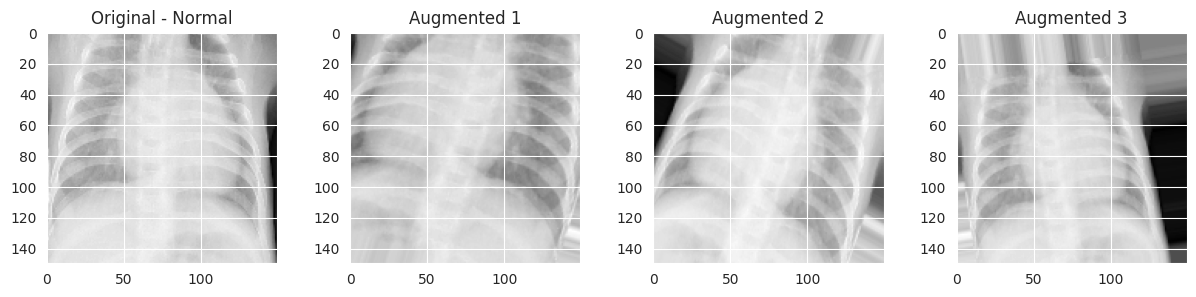

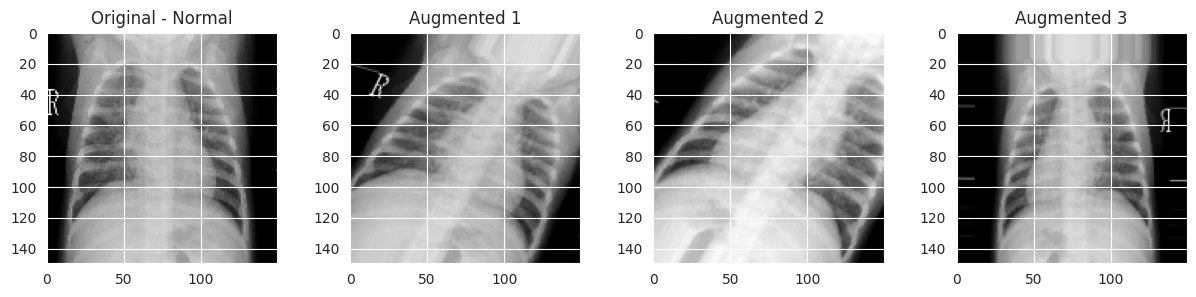

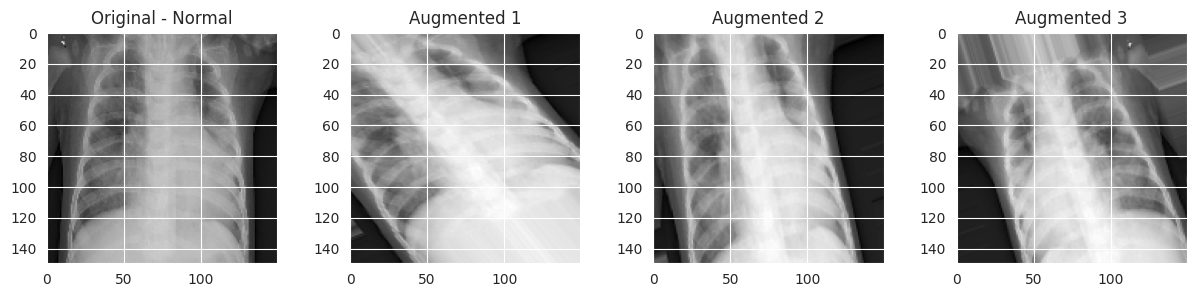

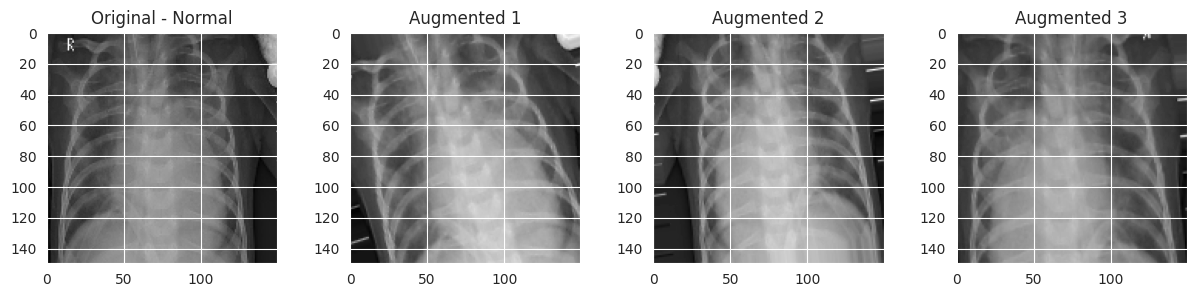

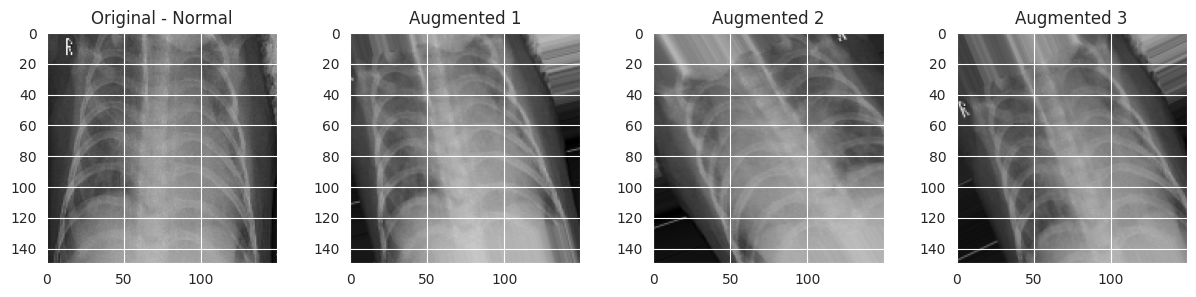

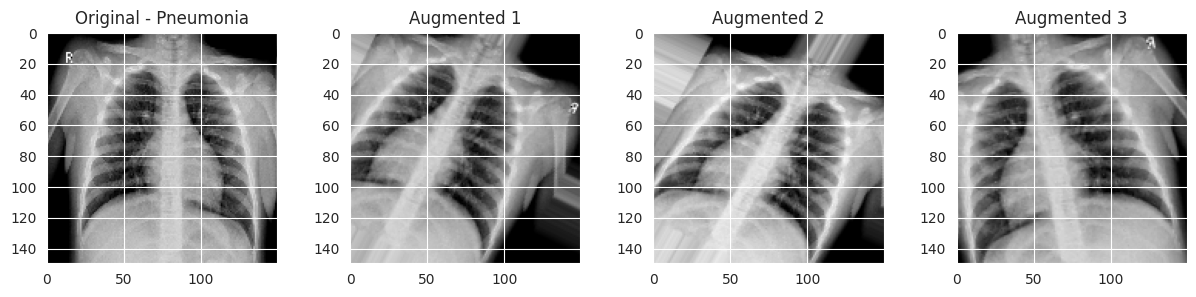

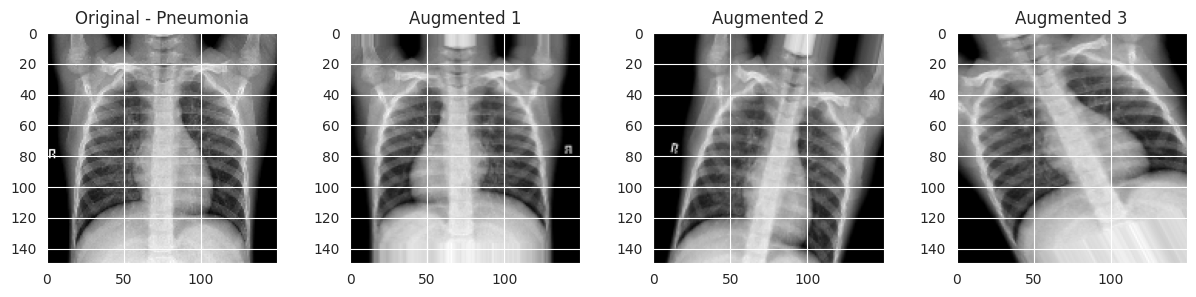

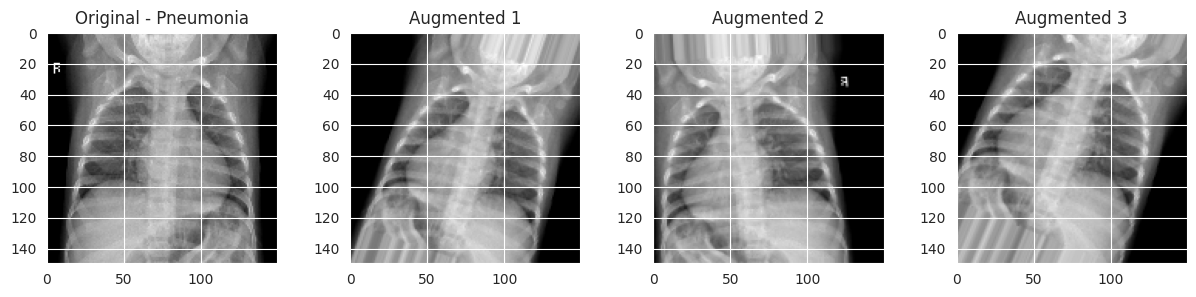

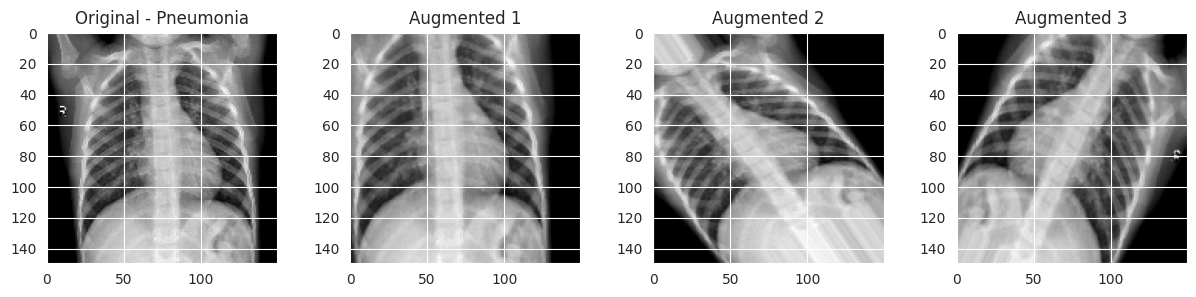

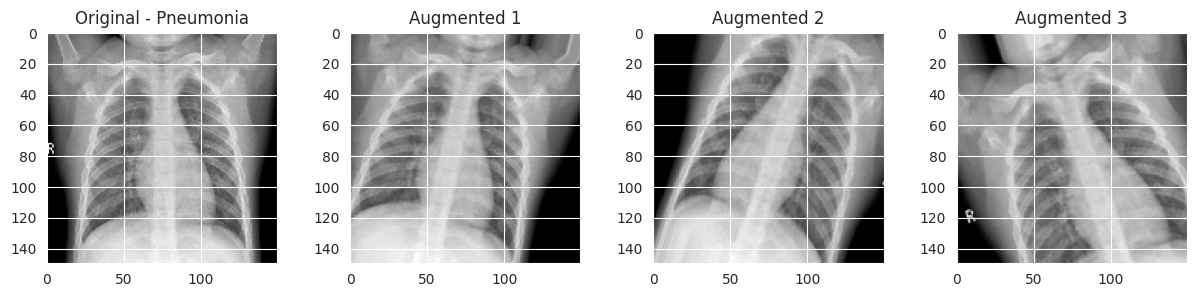

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape)  # Adding Gaussian noise
)

# Fit the datagen on the training data
datagen.fit(x_train)

# Print a few sample augmented images
num_samples = 5  # Number of sample images to display
classes = ["Normal", "Pneumonia"]

for cls in classes:
    class_indices = np.where(y_train == (1 if cls == "Pneumonia" else 0))[0]

    for idx in class_indices[:num_samples]:
        original_image = x_train[idx]
        original_label = y_train[idx]

        plt.figure(figsize=(15, 3))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image.squeeze(), cmap='gray')
        plt.title(f"Original - {cls}")

        # Generate and display augmented images
        for i in range(3):  # Generate 3 augmented images per original image
            augmented_image = datagen.random_transform(original_image)
            plt.subplot(1, 4, i + 2)
            plt.imshow(augmented_image.squeeze(), cmap='gray')
            plt.title(f"Augmented {i + 1}")

        plt.show()


In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('model.pkl', 'wb'))

In [ ]:
# Save the trained model
model.save("TrainedModel.h5")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("TrainedModel.h5")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model("TrainedModel.h5")

# Define the image size used for training
img_size = 150  # Adjust this according to your model's input size

# Load and preprocess the user-provided image
image_path = "/content/drive/MyDrive/Colab Notebooks/chest_xray/train/NORMAL/IM-0117-0001.jpeg"
img = image.load_img(image_path, target_size=(img_size, img_size), color_mode="grayscale")
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values to the range [0, 1]

# Predict output values
predicted_probabilities = model.predict(img_array)

if predicted_probabilities[0] > 0.05:
    prediction = "No Pneumonia"
else:
    prediction = "Pneumonia"

print("Predicted:", prediction)


1/1 [==============================] - 0s 126ms/step
Predicted: No Pneumonia


In [ ]:
# Load and preprocess the user-provided image
image_path ="/content/drive/MyDrive/Colab Notebooks/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg"  # Replace with the actual image path
img = image.load_img(image_path, target_size=(img_size, img_size), color_mode="grayscale")
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values to the range [0, 1]

# Predict output values
predicted_probabilities = model.predict(img_array)

if predicted_probabilities[0] > 0.05:
    prediction = "No Pneumonia"
else:
    prediction = "Pneumonia"

print("Predicted:", prediction)


1/1 [==============================] - 0s 20ms/step
Predicted: Pneumonia


In [ ]:
!pip install flask-ngrok
!pip install flask==0.12.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: flask
    Found existing installation: Flask 2.2.5
    Uninstalling Flask-2.2.5:
      Successfully uninstalled Flask-2.2.5


In [ ]:
!pip install pyngrok==4.1.1
!ngrok authtoken '2UVhhe5FS2TkhrWv4VbKhxySTpe_6jFJ6L1GijgFSCmwSdVCd'

  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15963 sha256=647e0a6d567d2e90b4da30720af00ec330d8b135a74377c64b0ff6c4262cfcd2
  Stored in directory: /root/.cache/pip/wheels/4c/7c/4c/632fba2ea8e88d8890102eb07bc922e1ca8fa14db5902c91a8
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/chest X-ray

/content/drive/MyDrive/Colab Notebooks/chest X-ray


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template
import numpy as np

In [ ]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import numpy as np
import pickle
from tensorflow.keras.preprocessing import image
from io import BytesIO

app = Flask(__name__)
run_with_ngrok(app)
model = pickle.load(open('model.pkl', 'rb'))
img_size = 150

# Threshold probability value for pneumonia detection
threshold = 0.5

def get_prediction_text(probability):
    if probability <= threshold:
        return "Pneumonia Detected"
    else:
        return "Pneumonia Not Detected"

@app.route('/')
def home():
    return render_template('index.html', output="")

@app.route('/getprediction', methods=['POST'])
def getprediction():
    if 'image' not in request.files:
        return render_template('index.html', output='No image uploaded.')

    uploaded_image = request.files['image']

    if uploaded_image.filename == '':
        return render_template('index.html', output='No image selected.')

    img = image.load_img(BytesIO(uploaded_image.read()), target_size=(img_size, img_size), color_mode="grayscale")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    prediction_text = get_prediction_text(prediction[0][0])

    return render_template('index.html', output=prediction_text)

if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://b811-35-243-132-222.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [26/Aug/2023 15:12:29] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 198ms/step


INFO:werkzeug:127.0.0.1 - - [26/Aug/2023 15:12:38] "POST /getprediction HTTP/1.1" 200 -


1/1 [==============================] - 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [26/Aug/2023 15:12:51] "POST /getprediction HTTP/1.1" 200 -


In [ ]:
tf.keras.models.save_model(model,'my_model.hdf5')

In [8]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 32.5 MB/s eta 0:00:00
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1


In [48]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st
from tensorflow.keras.models import load_model


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Pneumonia detection
         """
         )

file = st.file_uploader("Please upload the image", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (150,150)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        #img_resize = (cv2.resize(image, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.

        img_reshape = image[np.newaxis,...]

        prediction = model.predict(img_reshape)

        return prediction
if file is None:
    st.text("Please upload an image")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    pneumonia_probability = predictions[0]  # Modify this based on your model's output

    # You can set a threshold to decide if pneumonia is detected or not
    threshold = 0.5  # Modify this threshold as needed

    # Determine if pneumonia is detected based on the threshold
    pneumonia_detected = pneumonia_probability >= threshold

    # Display the result
    if pneumonia_detected:
        st.write("No Pneumonia Detected")
    else:
        st.write("Pneumonia Detected")




Overwriting app.py


In [18]:
!pip install pyngrok

In [42]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [43]:
!streamlit run app.py &>/dev/null&

In [44]:
!ngrok authtoken '2UVhhe5FS2TkhrWv4VbKhxySTpe_6jFJ6L1GijgFSCmwSdVCd'

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [31]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2023-08-29 10:01:17--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]  13.28M  5.27MB/s    in 2.5s    

2023-08-29 10:01:21 (5.27 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [13921656/13921656]



In [13]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [52]:
get_ipython().system_raw('./ngrok http 8501 &')

In [53]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print(json.load(sys.stdin)["tunnels"][0]["public_url"])'


https://79ab-35-240-142-140.ngrok-free.app


In [ ]:
!streamlit run /content/app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.240.142.140:8501

2023-08-29 10:20:56.555100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 10:20:57.896053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-29 10:20:59.605660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-29 10:20:59.638696: I tensorflow/compiler/xla/stream_executor/cuda